In [5]:
# Import general util libraries

import torch
from torch.utils import data
import torch.nn as nn
from torch.optim import Adam
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
plt.style.use('seaborn') 
matplotlib.rcParams['font.family'] = 'serif'  
os.environ['KMP_DUPLICATE_LIB_OK']='True' # Avoid iOS bug with pyplot. 


# Data loading
from utils.dlc_practical_prologue import generate_pair_sets



# Import models
from models.LeNet import lenet
from models.LinearReluNet import linear_relu_net
from models.SimpleConvNet import simple_conv_net
from models.ResNet import residual_net
from models.LeNet_2 import lenet_2
from models.Conv_Net_2 import conv_net_2
from models.Siamese import siamese
from models.Aux import aux

# Import plot utils
from utils.plot_utils import *
from utils.ml_utils import *
from utils.data_utils import *
from utils.metrics import *



In [6]:
N = 1000  # Number of pairs
NN_ARGS = {"input_size": 14 * 14, "num_classes": 10}
DROP = {"d1" : 0, "d2" : 0}
DROP_RES = {"d" : 0.15}
DROP_RES_2 = {"d" : 0.15, "input_channels" : 2}
BATCH_SIZE = 10
NUM_EPOCHS = 25
NUM_ITER = 1
MODELS = {
    "SimpleConvNet" : {"args" : DROP, "f1" :simple_conv_net, "f2" :conv_net_2, "flatten": False, "name":"Simple Conv" },
    "LinearRelu": {"args": NN_ARGS, "f1": linear_relu_net, "flatten": True, "name":"Linear ReLu"},
    "LeNet": {"args": DROP, "f1": lenet,"f2":lenet_2, "flatten": False, "name":"LeNet"},
    "ResNet": {"args": DROP_RES, "f1": residual_net, "args2": DROP_RES_2,"flatten": False, "name":"Residual Net"},
    "Siamese" : {"f1" : siamese},
    "Aux" : {"f1" : aux, "name": "Aux"}
}

In [7]:
def full_train_test(model_info, num_iter, num_epochs, data_size, batch_size, nb_channels = 2,split= True, weight_sharing = True, auxiliary = False, r = 1, verbose=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Copy all model parameters to the GPU
    
    
    if (split):
        args = model_info.get("args")
        if args is None:
            model = model_info.get('f1')()
        else:
            model = model_info.get('f1')(**args)
            model_1 = model
        args = {"m1": model_1, "ws": weight_sharing, "flatten":model_info.get('flatten')}
        model = siamese(**args)
    else:
        if (model_info.get("name") == "Residual Net"):
            args = model_info.get('args'+str(nb_channels))
            model = model_info.get('f1')(**args)
        else:
            args = model_info.get("args")    
            model =  model_info.get('f'+ str(nb_channels))(**args)
        if (auxiliary) & (nb_channels == 2):
            model_1 = model
            args = {"m1": model_1, "ws": weight_sharing, "flatten":model_info.get('flatten')}
            model = aux(**args)
            
    model = model.to(device)
    
    all_train_losses = [] 
    all_test_losses = []
    
    all_test_accuracies = []
    
    for it in range(1, num_iter + 1):
        print("Iteration %d" % it)
        
        # Generate a new dataset
        train_input, train_target, train_classes, test_input, test_target, test_classes = generate_pair_sets(data_size)
        
        if nb_channels==1: 
            
        # Build Keras loaders for train and test datasets batches.
            tr_loader, te_loader = build_train_loaders(train_input, train_classes, test_input, test_classes, batch_size)
            tr_losses, te_losses = train_model(model, device, num_epochs, tr_loader, te_loader, model_info.get('flatten'), verbose)
        else:
            
            tr_loader, te_loader = build_two_ch_loader(train_input,train_classes, train_target, test_input, test_classes,test_target,  batch_size)
            tr_losses, te_losses = train_model_two_ch(model, device, num_epochs, tr_loader, te_loader, split,weight_sharing,auxiliary, r, model_info.get('flatten'), verbose)
        

       # plot_train_test(tr_losses, te_losses, model_info.get('name'))
    
        if verbose:
            print("Final train loss: %.4f" % tr_losses[-1])
            print("Final test loss: %.4f" % te_losses[-1])
        
        all_train_losses.append(tr_losses)
        all_test_losses.append(te_losses)
        
        _,_,_, acc_input, acc_target, _ = generate_pair_sets(data_size)
        acc_loader = build_test_loader(acc_input, acc_target, batch_size)
        
        if nb_channels == 1:
            acc = accuracy(model, acc_loader, False , model_info.get('flatten') )
        else: 
            acc = accuracy_two_ch(model, acc_loader,split,auxiliary, model_info.get('flatten') )
                
        if verbose:
            print("Test accuracy: %.4f" % acc)
        all_test_accuracies.append(acc)
    
    #if weight_sharing == True:
    plot_losses(all_train_losses, all_test_losses, model_info.get('name'))
    
    plot_accuracy(all_test_accuracies, model_info.get('name'))
    

       
            


In [8]:
full_train_test(MODELS.get("LinearRelu"), NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,True,False,False)

Iteration 1


KeyboardInterrupt: 

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


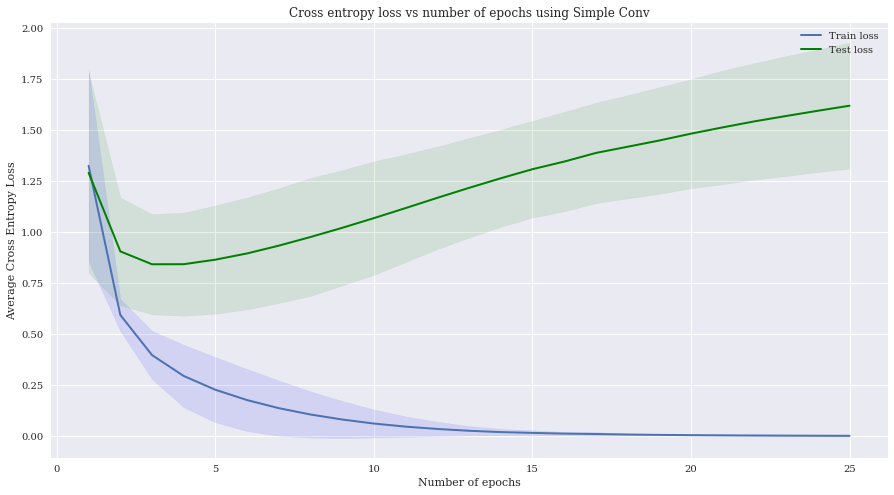

Test accuracy mean = 0.6990000000000001


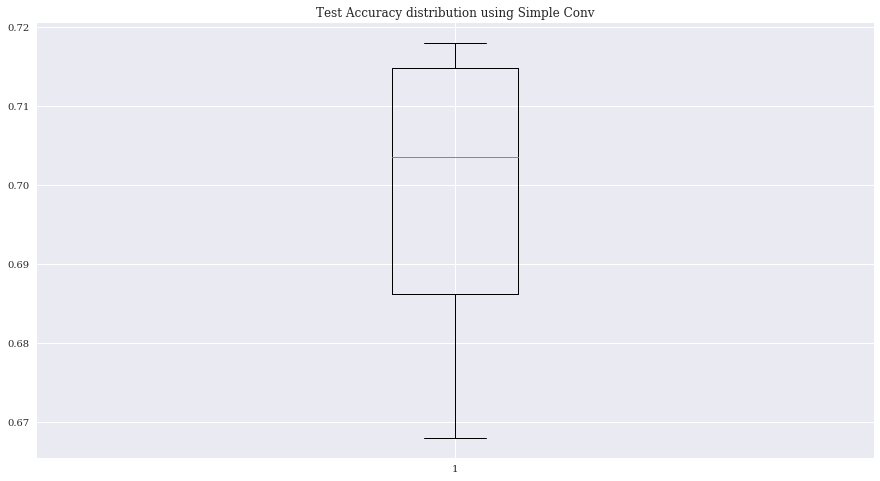

Conv_Net_2(
  (cnn_layers): Sequential(
    (C1): Conv2d(2, 6, kernel_size=(2, 2), stride=(1, 1))
    (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu1): ReLU()
    (D1): Dropout(p=0, inplace=False)
    (S2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C3): Conv2d(6, 7, kernel_size=(2, 2), stride=(1, 1))
    (BN2): BatchNorm2d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu3): ReLU()
    (D2): Dropout(p=0, inplace=False)
    (S4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C5): Conv2d(7, 100, kernel_size=(2, 2), stride=(1, 1))
    (BN3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Relu5): ReLU()
  )
  (linear_layers): Sequential(
    (F6): Linear(in_features=100, out_features=84, bias=True)
    (Relu6): ReLU()
    (F7): Linear(in_features=84, out_features=2, bias=True)
    (LogSoftmax): L

In [5]:
full_train_test(MODELS.get('SimpleConvNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,False, False, False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


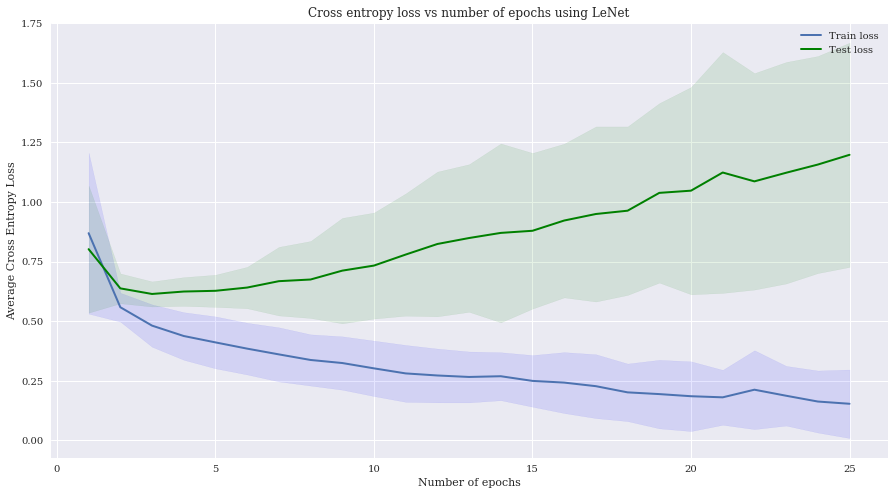

Test accuracy mean = 0.7332


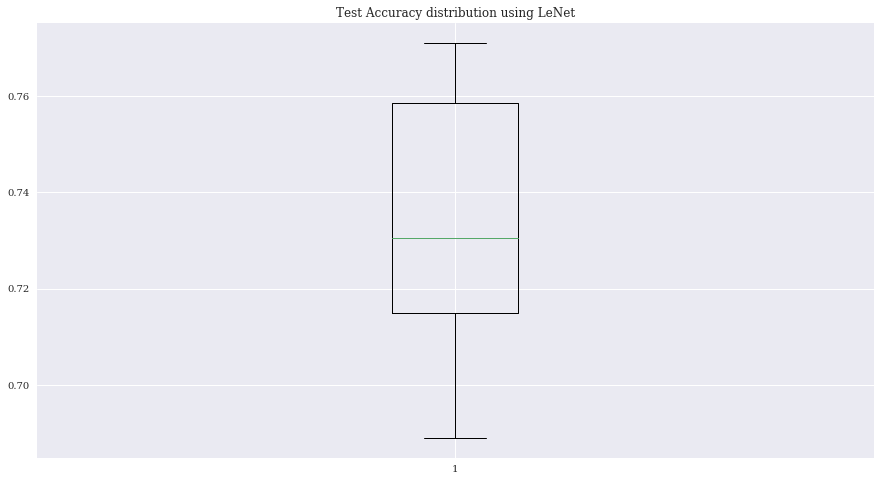

LeNet_2(
  (cnn_layers): Sequential(
    (C1): Conv2d(2, 6, kernel_size=(2, 2), stride=(1, 1))
    (Relu1): ReLU()
    (D1): Dropout(p=0, inplace=False)
    (S2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C3): Conv2d(6, 7, kernel_size=(2, 2), stride=(1, 1))
    (Relu3): ReLU()
    (D2): Dropout(p=0, inplace=False)
    (S4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C5): Conv2d(7, 120, kernel_size=(2, 2), stride=(1, 1))
    (Relu5): ReLU()
  )
  (fully_connected): Sequential(
    (F6): Linear(in_features=120, out_features=84, bias=True)
    (Relu6): ReLU()
    (F7): Linear(in_features=84, out_features=2, bias=True)
    (LogSoftmax): LogSoftmax()
  )
)

In [6]:
full_train_test(MODELS.get('LeNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,False, False, False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


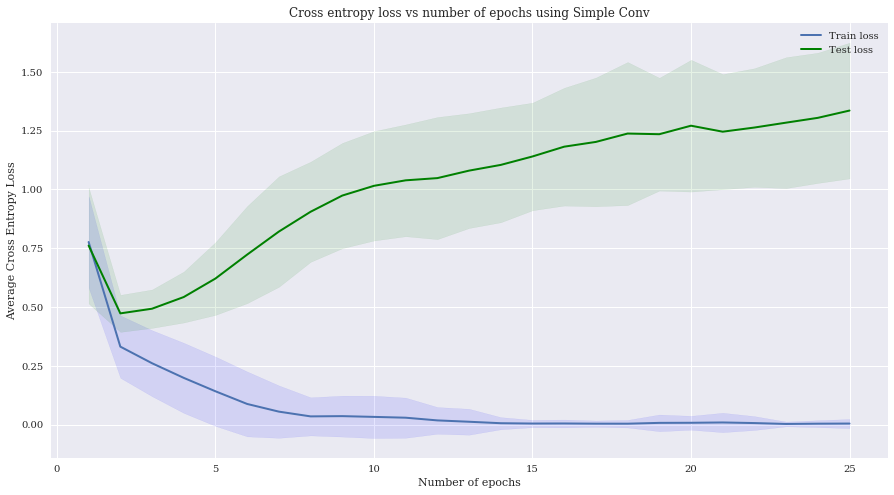

Test accuracy mean = 0.8034000000000001


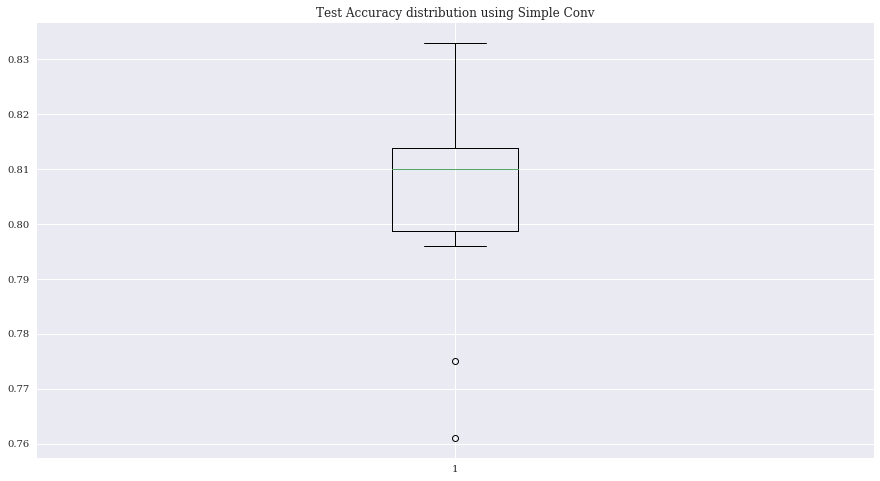

In [12]:
full_train_test(MODELS.get('SimpleConvNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,True, True, False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


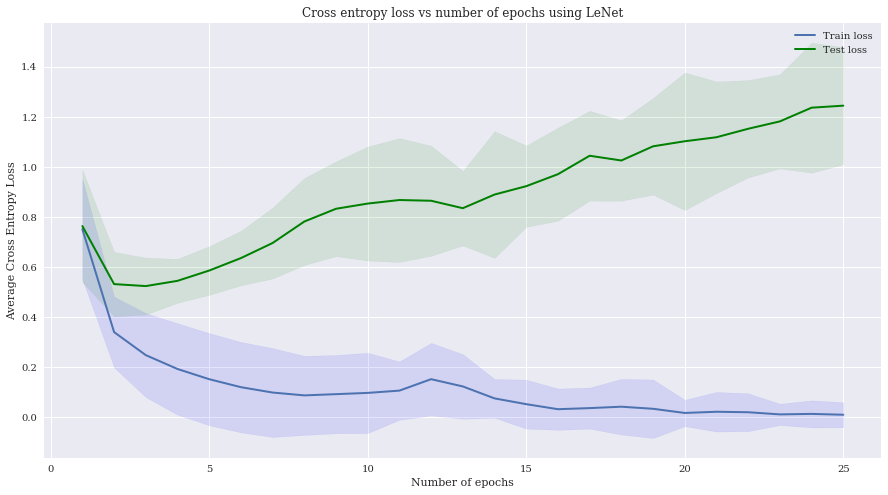

Test accuracy mean = 0.8186


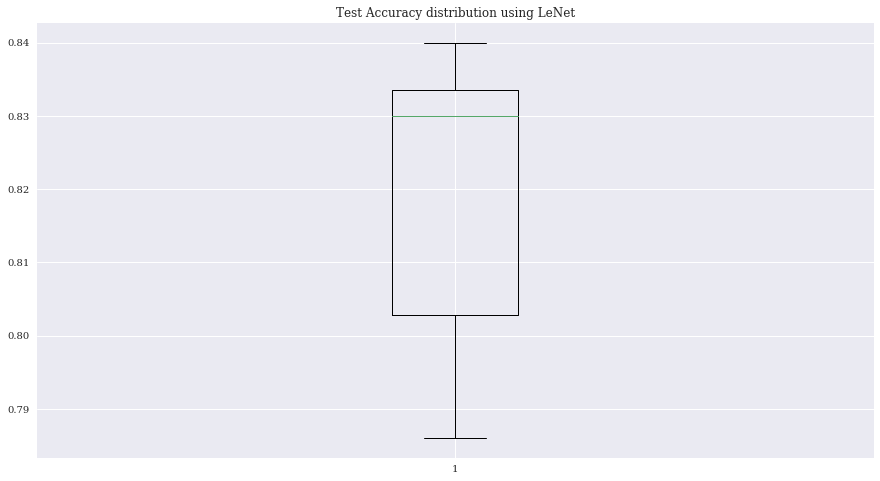

In [13]:
full_train_test(MODELS.get('LeNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,True, True, False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


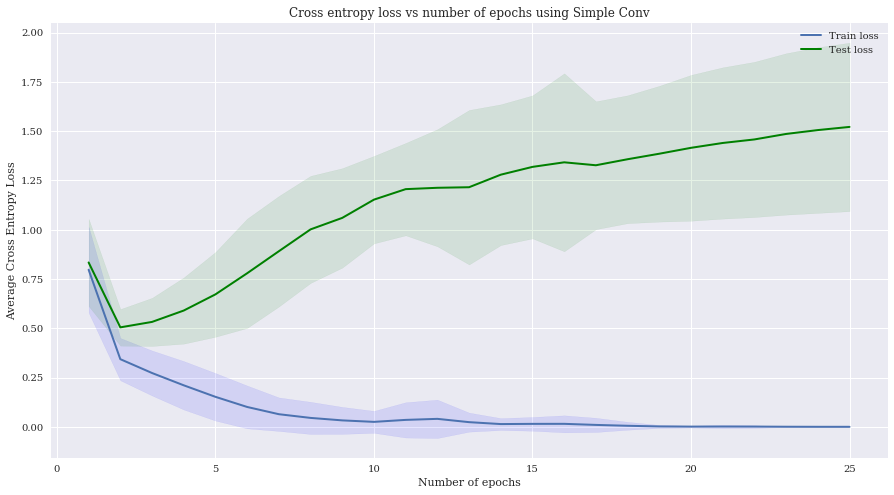

Test accuracy mean = 0.7942


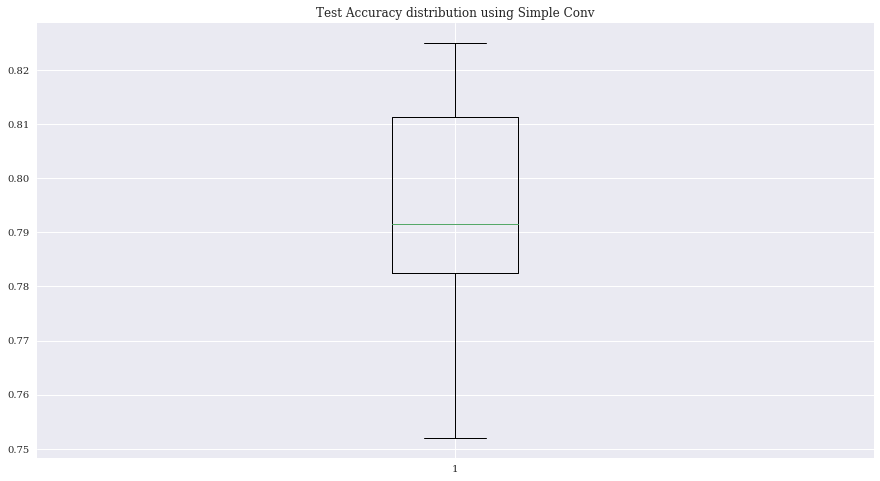

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


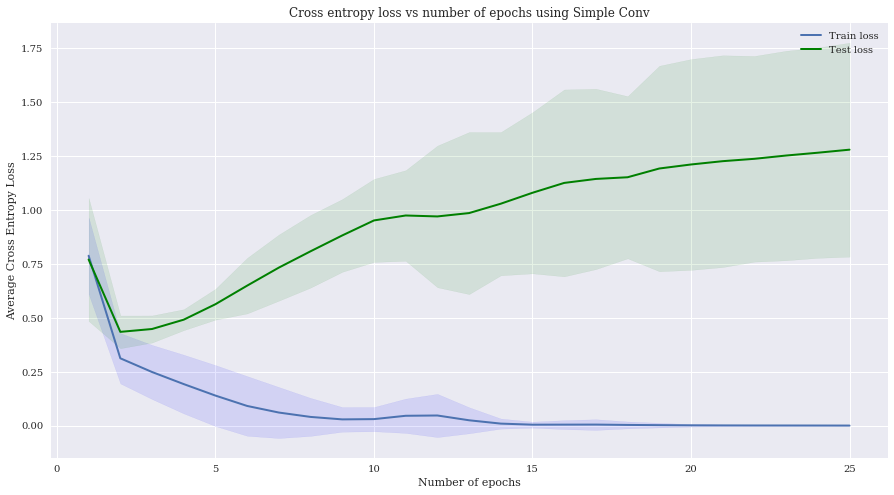

Test accuracy mean = 0.8103999999999999


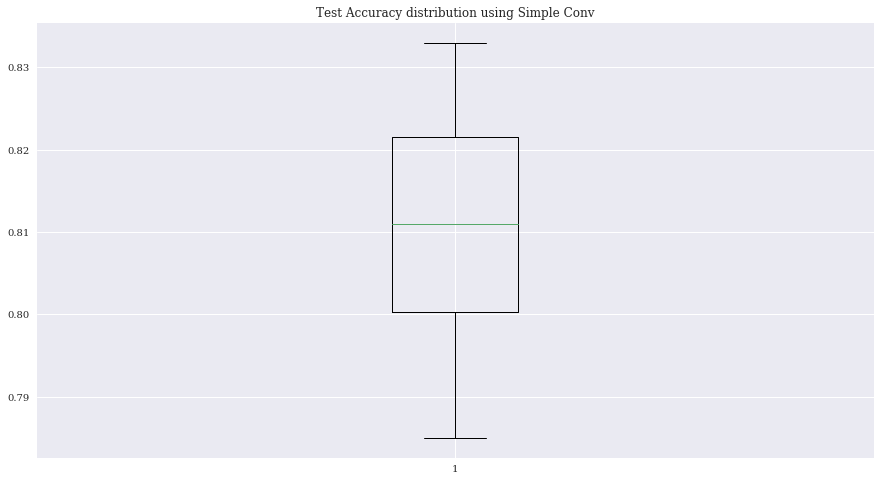

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


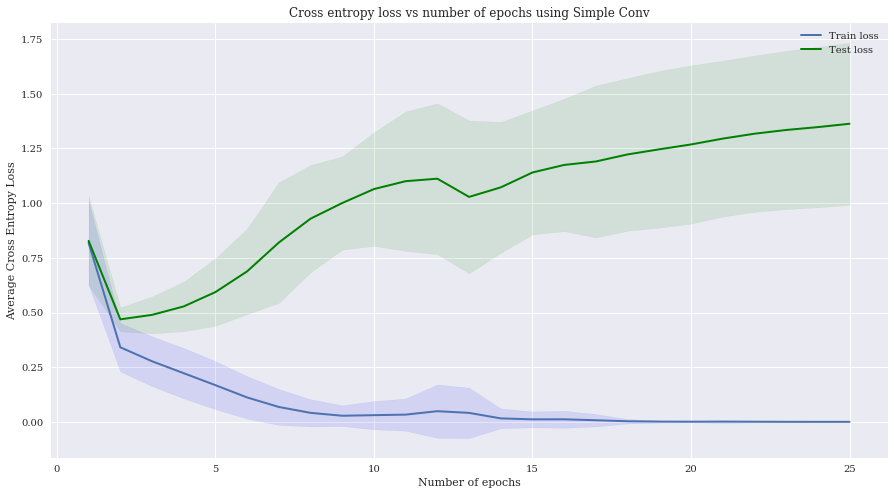

Test accuracy mean = 0.8108000000000001


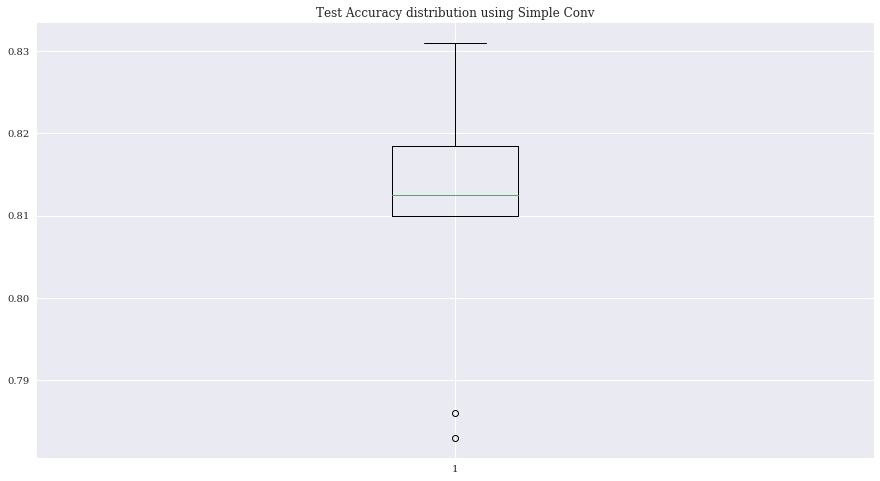

In [15]:
for i in [0.4, 0.8, 1.2]:
    full_train_test(MODELS.get('SimpleConvNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,True, False, True, i)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


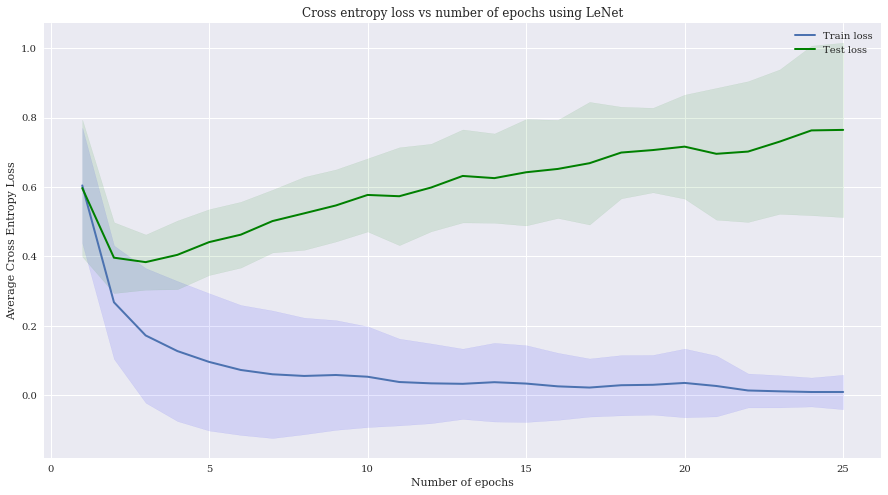

Test accuracy mean = 0.8778


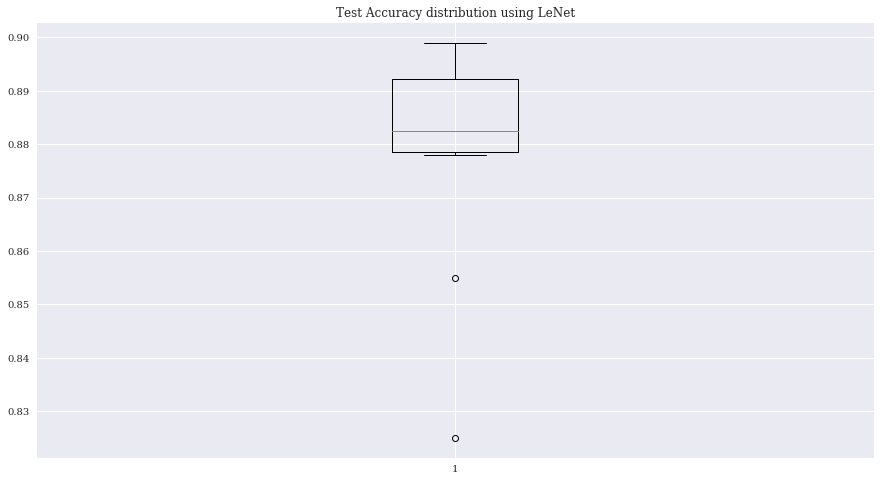

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


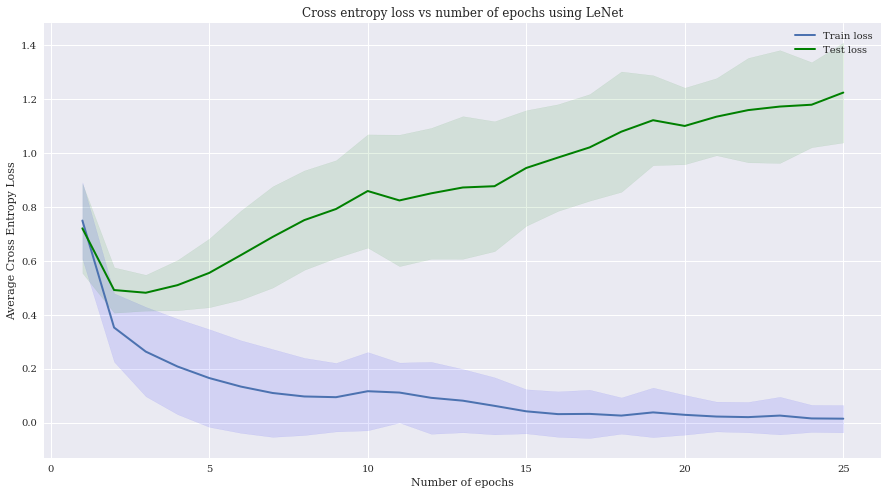

Test accuracy mean = 0.8142999999999999


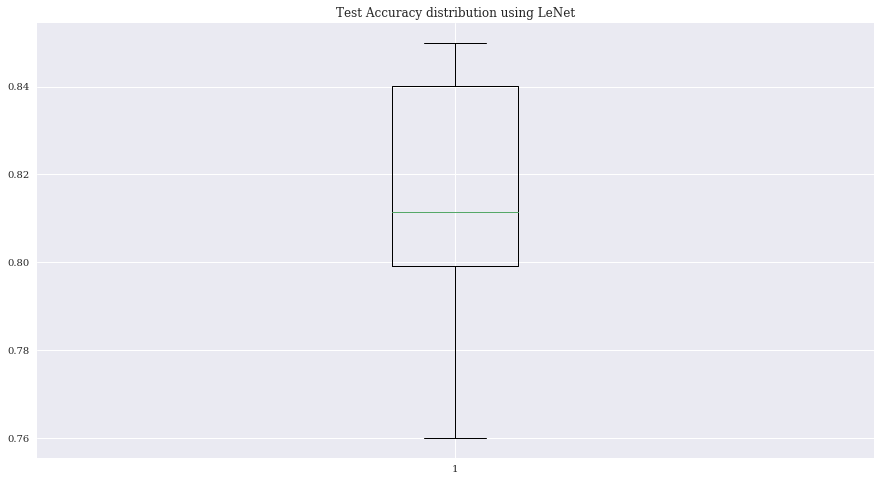

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


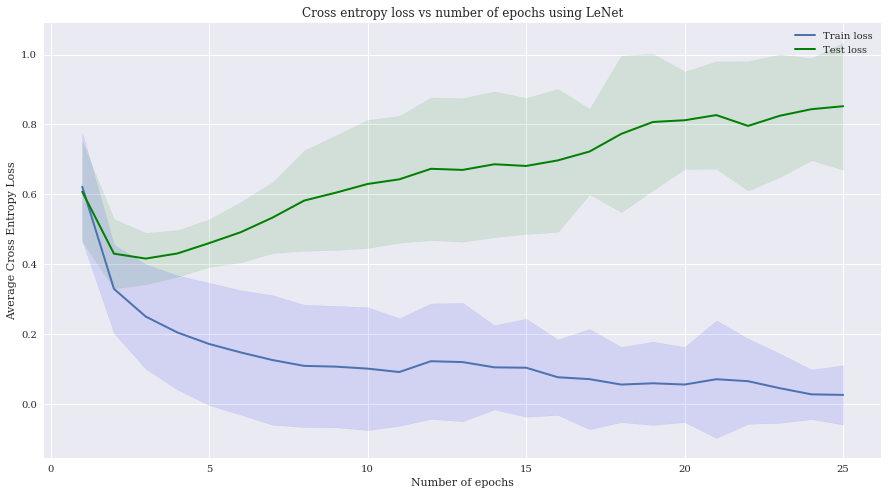

Test accuracy mean = 0.8503000000000001


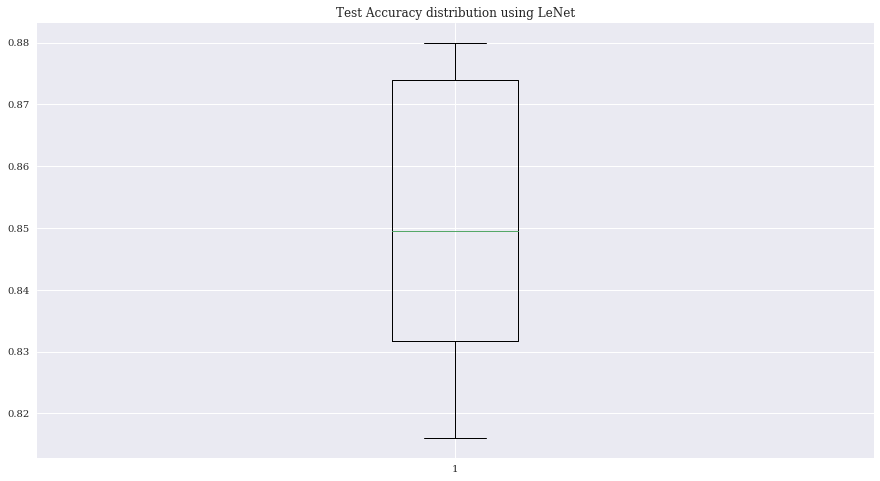

In [18]:
for i in [0.4, 0.8, 1.2]:
    full_train_test(MODELS.get('LeNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,True, False, True, i)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


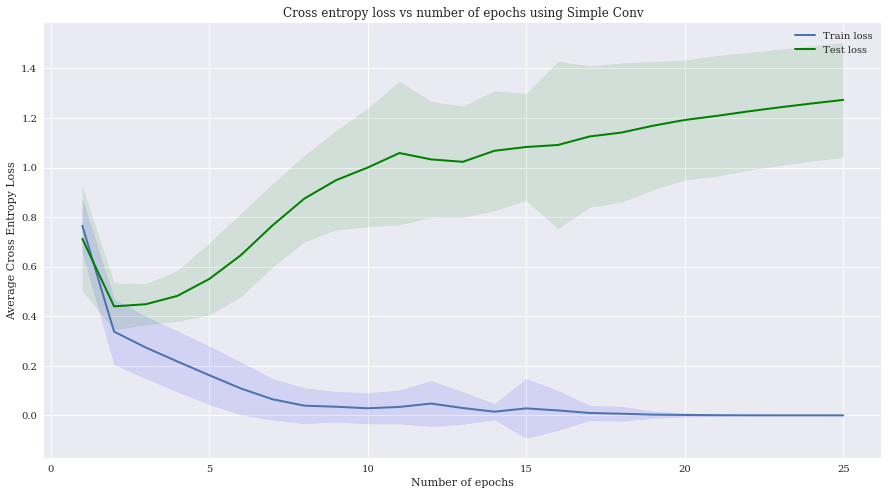

Test accuracy mean = 0.8114000000000001


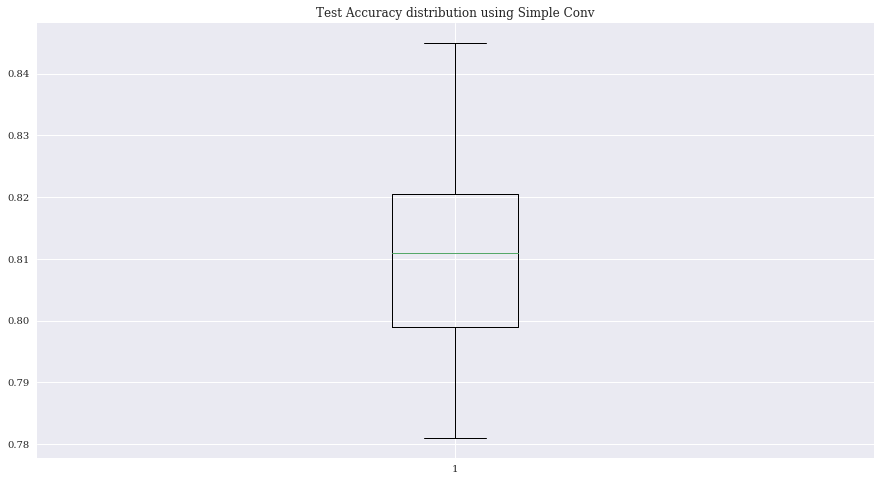

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


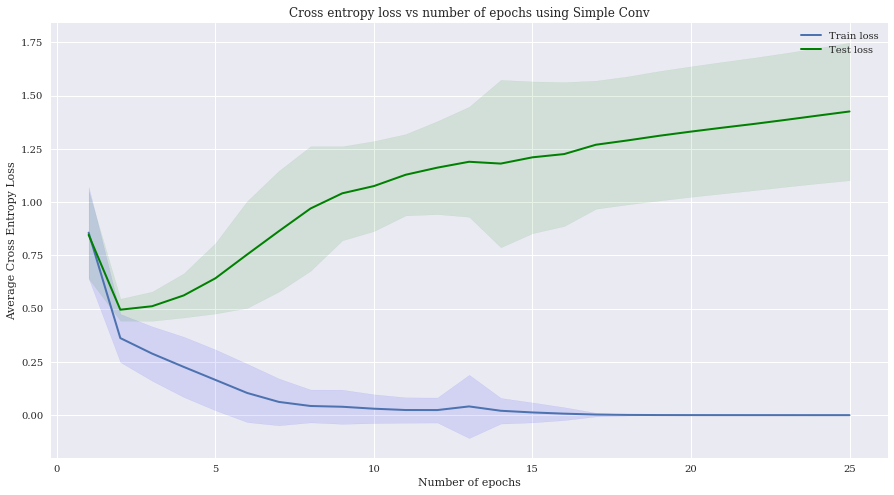

Test accuracy mean = 0.7904


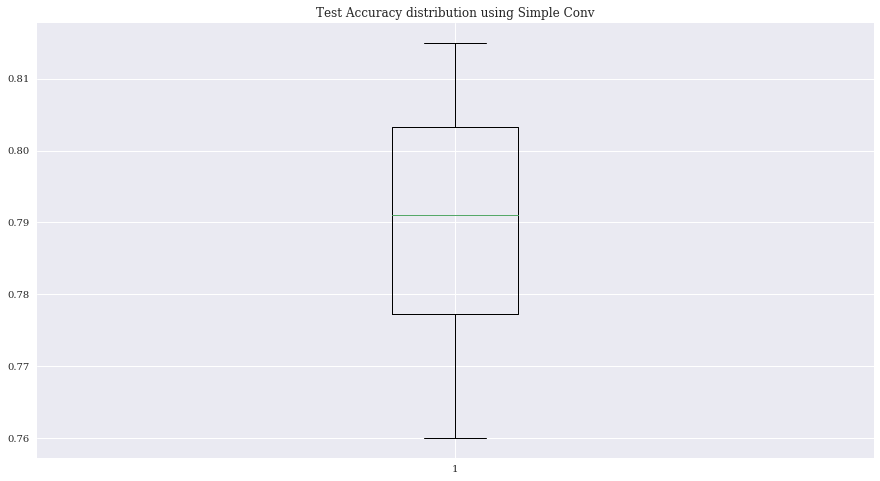

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


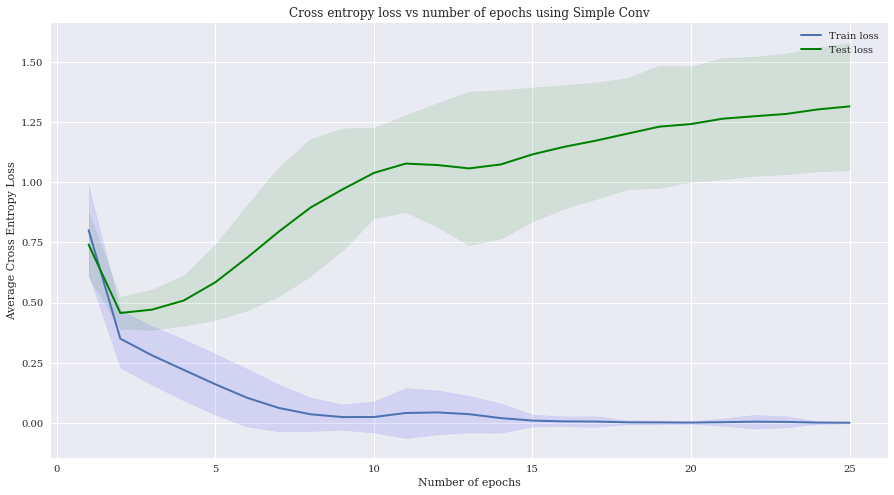

Test accuracy mean = 0.8183


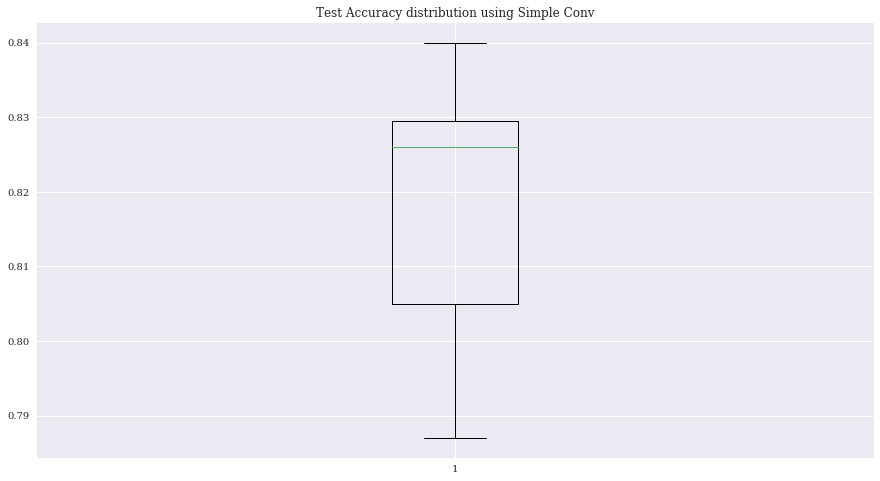

In [19]:
for i in [0.4, 0.8, 1.2]:
    full_train_test(MODELS.get('SimpleConvNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,True, True, True, i)

In [ ]:
for i in [0.4, 0.8, 1.2]:
    full_train_test(MODELS.get('LeNet'),  NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, 2,True, True, True, i)

Iteration 1


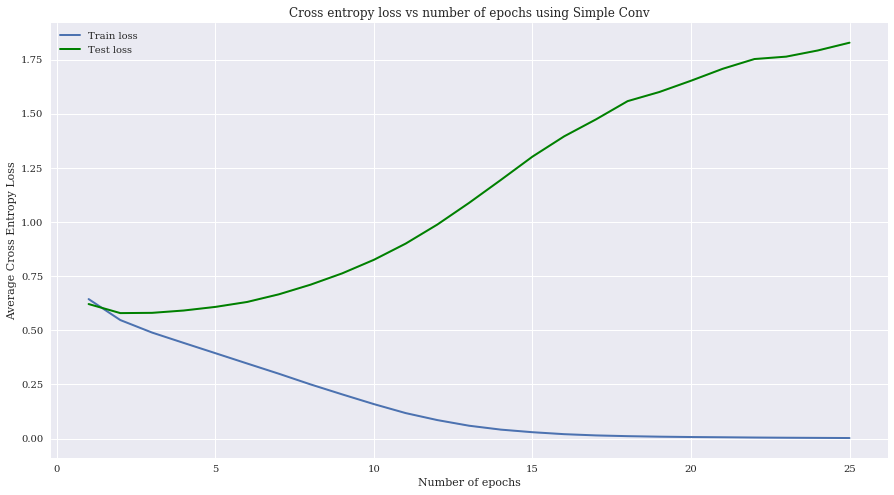

Test accuracy mean = 0.684


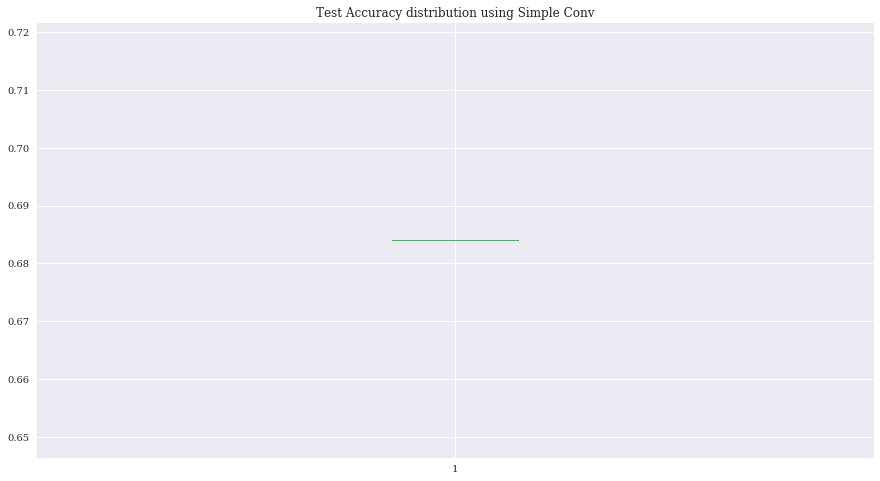

In [13]:
full_train_test(MODELS.get("SimpleConvNet"), 1, NUM_EPOCHS, N, BATCH_SIZE, nb_channels = 2, True,,verbose = False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


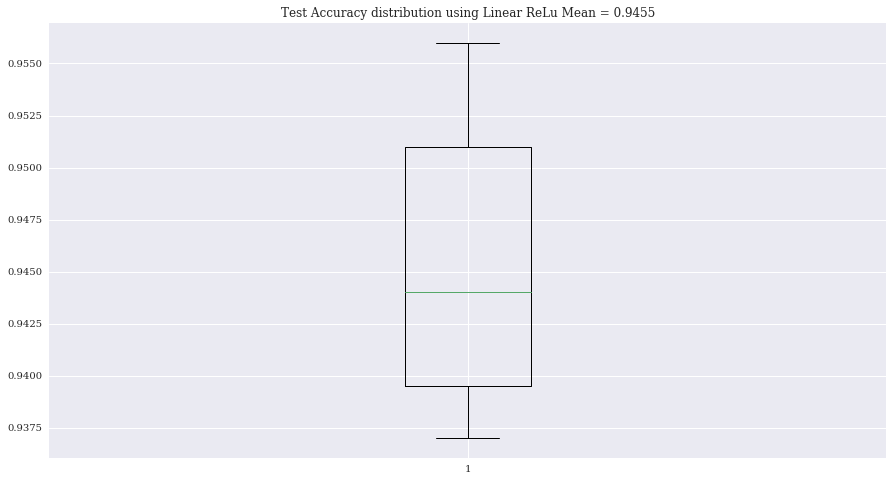

In [7]:
full_train_test(MODELS.get("LinearRelu"), NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = False,verbose = False)

Iteration 1


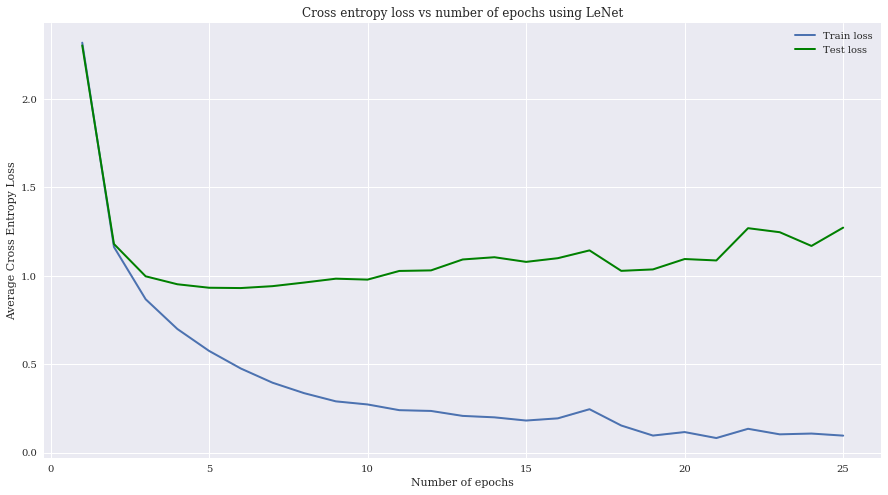

Test accuracy mean = 0.892


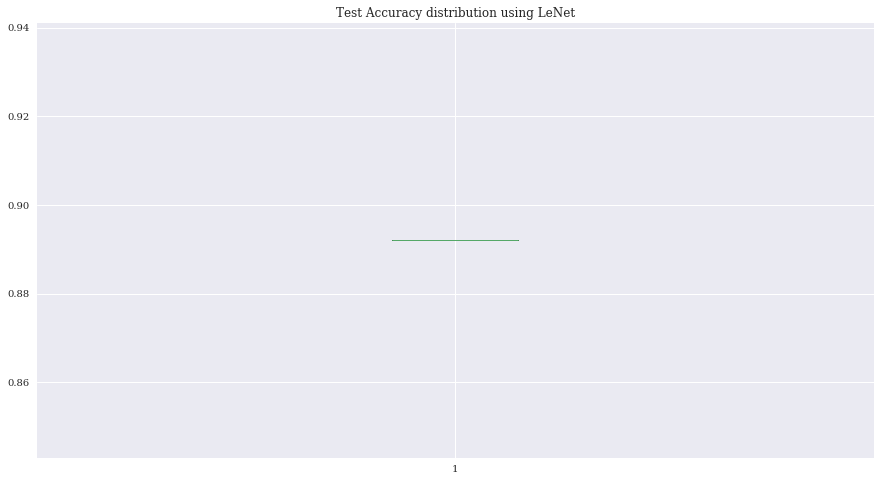

In [23]:
model = full_train_test(MODELS.get("LeNet"), NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = True,verbose = False)

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10


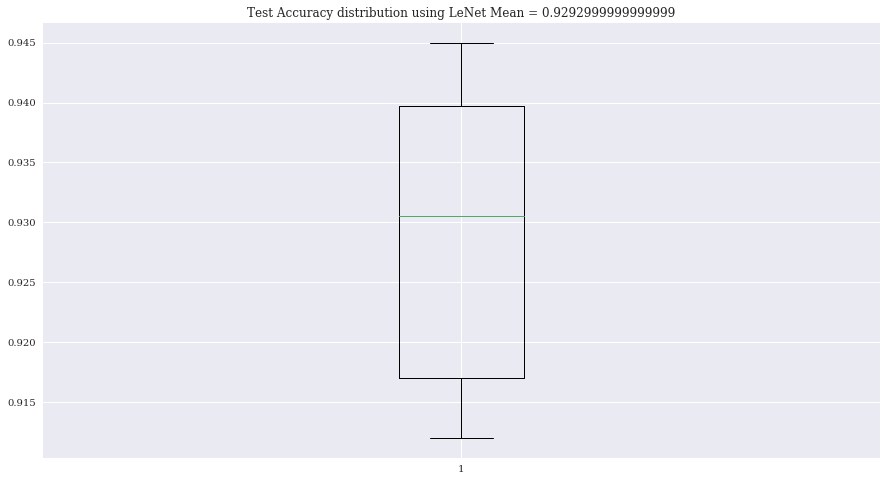

In [9]:
full_train_test(MODELS.get("LeNet"), NUM_ITER, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = False,verbose = False)

Iteration 1


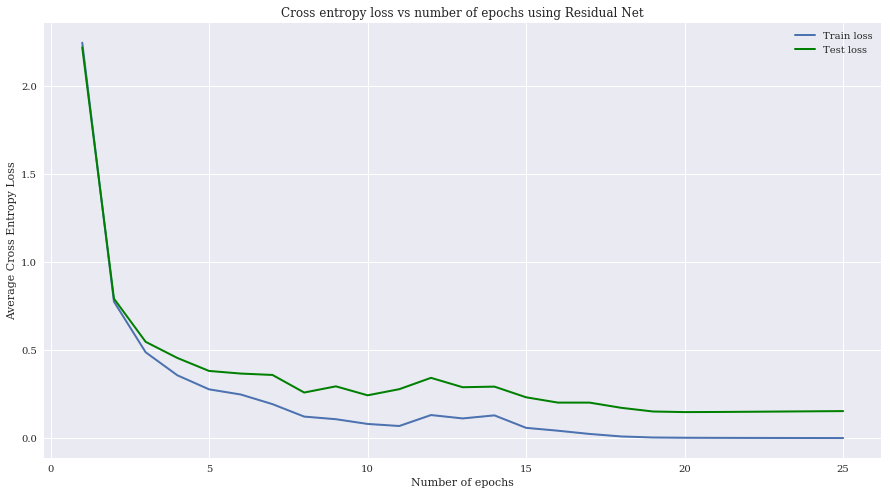

Test accuracy mean = 0.982


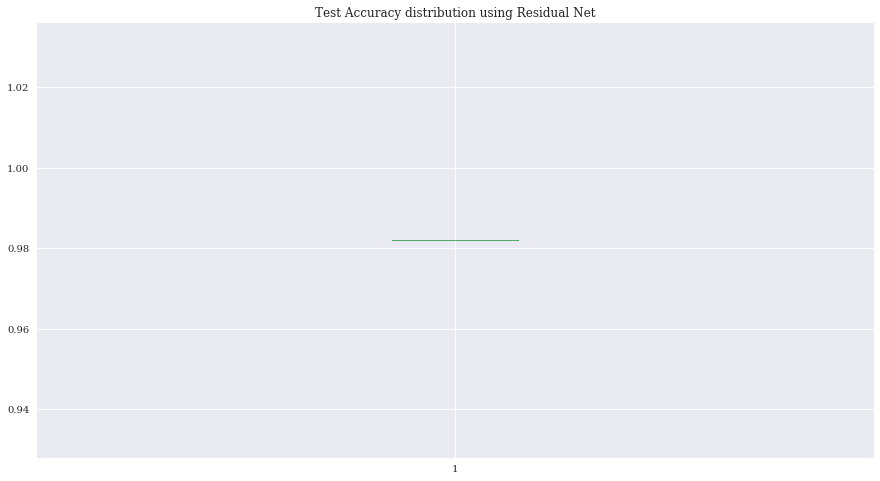

In [6]:
full_train_test(MODELS.get("ResNet"), 1, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = True,verbose = False)

Iteration 1
Test accuracy mean = 0.977


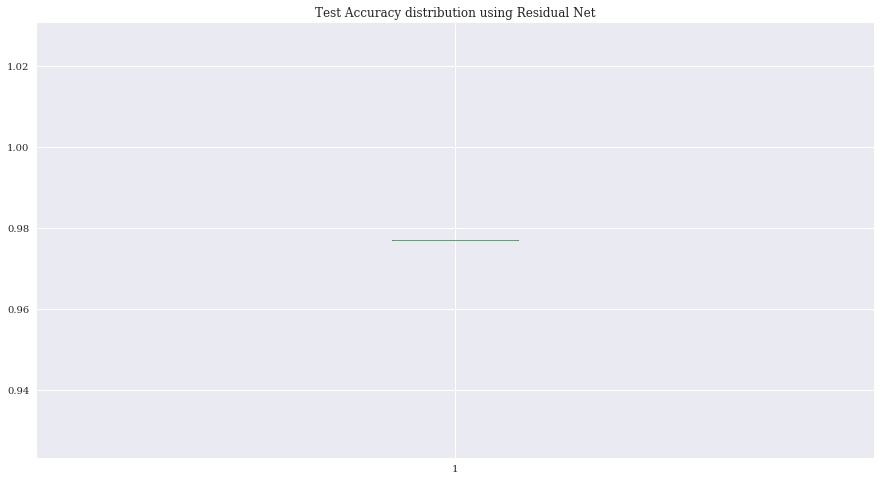

In [7]:
full_train_test(MODELS.get("ResNet"), 1, NUM_EPOCHS, N, BATCH_SIZE, weight_sharing = False,verbose = False)